# 4 Pre-Processing Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, we performed preliminary assessments of data quality and refined the question to be answered. We determined that predicting market rent is the primary aim. That market rent can be applied to a Return-on-Investment calculation for each house for sale, determining whether or not that house would make a good investment on some ROI threshold. 

Before we can develop a predictive model, we need to encode categoricals, scale, and reduce dimensionality.

## 4.2 Imports<a id='4.3_Imports'></a>

In [22]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
import datetime
import math

from library.sb_utils import save_file

## 4.3 Load Data<a id='4.4_Load_Data'></a>

In [23]:
corporate_data = pd.read_csv('../data/corporate_properties_values_Demo.csv')
corporate_data.head().T

,0,1,2,3,4
property_code,10000753,10000801,10000898,10000946,10001199
address,10627 Kittredge St,10705 Clermont St,10874 Fairfax Way,10944 Bellaire Way,11120 Sylvan Pl
city,Commerce City,Thornton,Thornton,Thornton,Parker
state,CO,CO,CO,CO,CO
zipcode,80022,80233,80233,80233,80138
beds,3,3,4,4,3
baths,2.5,2.0,2.0,2.0,2.0
sqft,1993,1544,1904,1800,1387
market_rent,2939.0,2529.0,2599.0,2485.0,2549.0
lat,39.88982,39.89058,39.89348,39.89548,39.51228


In [24]:
sale_data = pd.read_csv('../data/for_sale_Demo.csv')
sale_data.head().T

,0,1,2,3,4
address,5211 Willow Way,3547 S Ivanhoe Street,1128 S Jackson Street,2585 N Holly Street,1193 S Clarkson Street
city,Denver,Denver,Denver,Denver,Denver
zip,80238,80237,80210,80207,80210
beds,4.0,5.0,2.0,4.0,4.0
baths,4.0,4.0,2.0,2.0,2.0
sqft,2773,3269,1595,1795,2177
listPrice,750000,750000,750000,750000,750000
taxes,5431,2919,2935,2877,3038
lat,39.792285,39.651669,39.696093,39.754414,39.694933
lng,-104.886263,-104.922119,-104.943268,-104.922607,-104.978287


## 4.4 Manipulate Categorical Data <a id='4.5_Extract_Big_Mountain_Data'></a>

Let's start with the corporate owned properties. 
All of the properties are in Colorado, the state column doesn't add any information, let's remove it. The property_code is a unique, discrete piece of information with no relationship to outcomes, let's remove that too. 

In [25]:
# Drop uninformative 'state' and 'property_code' columns
corporate_data = corporate_data.drop(['state', 'property_code'], axis=1)

Let's rename a couple of features so they make sense across dataframes. Rename 'districtMatch' to 'district', and 'estimatedValue' to 'value'. We will do the same on the other dataframe once we begin pre-processing it. 

In [26]:
# Rename two columns in corporate data df
cols = {'districtMatch':'district', 'estimatedValue':'value'}
corporate_data = corporate_data.rename(columns=cols)

In [27]:
# rename sale_data columns
cols={'zip':'zipcode', 'listPrice':'value', 'districtMatch':'district'}
sale_data = sale_data.rename(columns=cols)

The 'city' and 'district' columns need to be changed to a numeric value. Use Dummy encoding (with one less column than one-hot to avoid double-representation and instability). 

In [28]:
corporate_data['city'].unique(), sale_data['city'].unique()

(array(['Commerce City', 'Thornton', 'Parker', 'Westminster', 'Henderson',
        'Aurora', 'Brighton', 'Denver', 'Centennial', 'Arvada',
        'Castle Rock', 'Highlands Ranch', 'Lakewood', 'Littleton',
        'Morrison', 'Castle Pines', 'Erie', 'Broomfield', 'Northglenn'],
       dtype=object),
 array(['Denver', 'Arvada', 'Lakewood', 'Centennial', 'Littleton',
        'Wheat Ridge', 'Golden', 'Aurora', 'Englewood', 'Morrison',
        'Westminster', 'Edgewater', 'Indian Hills', 'Greenwood Village',
        'Commerce City', 'Idledale'], dtype=object))

In [29]:
corporate_data['district'].unique(), corporate_data['district'].unique()

(array(['Brighton 27J School District', 'Adams 12 Five Star Schools',
        'Douglas County RE 1 School District',
        'Jefferson County R-1 School District',
        'Cherry Creek 5 School District',
        'Adams-Arapahoe 28J School District',
        'Denver County 1 School District',
        'Westminster 50 School District', 'Littleton 6 School District',
        'Mapleton 1 School District',
        'St. Vrain Valley RE 1J School District'], dtype=object),
 array(['Brighton 27J School District', 'Adams 12 Five Star Schools',
        'Douglas County RE 1 School District',
        'Jefferson County R-1 School District',
        'Cherry Creek 5 School District',
        'Adams-Arapahoe 28J School District',
        'Denver County 1 School District',
        'Westminster 50 School District', 'Littleton 6 School District',
        'Mapleton 1 School District',
        'St. Vrain Valley RE 1J School District'], dtype=object))

In [30]:
# Arvada will be the dropped column from city, because it is the first, alphabetically. 
# Adams 12 will be the dropped column from district. 
corporate_data = pd.get_dummies(corporate_data, columns=['city'], prefix='City', drop_first=True)
sale_data = pd.get_dummies(sale_data, columns=['city'], prefix='City', drop_first=True)
corporate_data = pd.get_dummies(corporate_data, columns=['district'], prefix='District', drop_first=True)
sale_data = pd.get_dummies(sale_data, columns=['district'], prefix='District', drop_first=True)

We have a problem with the HOA data. Some of the deployment data (houses for sale) have HOAs, but we don't have any information about whether the corporate properties have an HOA. So, we have no way to scale that data.
One idea is to combine the HOA price into the value of the house, over 30 years. Let's do that with the sales_data. 

In [31]:
# Roll HOA costs into the value of the house
sale_data['value'] = sale_data['value'] + (360 * sale_data['monthly_hoa'])

We have taxes for the sale data, because it is included in the listing. But, it is linearly related to the value of the house. Therefore, instead of *adding* tax data for the corporate-owned houses, we shall remove the tax data from the sale houses. 

In [32]:
# drop tax column because it's linearly related to sales price (percentage of sales price)
sale_data.drop('taxes', axis=1, inplace=True)

Feature names need to match, and be the same value / scale. Let's work on that. 

In [33]:
sale_data.columns.difference(corporate_data.columns)

Index(['City_Edgewater', 'City_Englewood', 'City_Golden',
       'City_Greenwood Village', 'City_Idledale', 'City_Indian Hills',
       'City_Wheat Ridge', 'District_Adams County 14 School District',
       'District_Englewood 1 School District',
       'District_Sheridan 2 School District', 'monthly_hoa'],
      dtype='object')

In [34]:
sale_data.columns, corporate_data.columns

(Index(['address', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'lat', 'lng',
        'monthly_hoa', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement', 'City_Aurora',
        'City_Centennial', 'City_Commerce City', 'City_Denver',
        'City_Edgewater', 'City_Englewood', 'City_Golden',
        'City_Greenwood Village', 'City_Idledale', 'City_Indian Hills',
        'City_Lakewood', 'City_Littleton', 'City_Morrison', 'City_Westminster',
        'City_Wheat Ridge', 'District_Adams County 14 School District',
        'District_Adams-Arapahoe 28J School District',
        'District_Cherry Creek 5 School District',
        'District_Denver County 1 School District',
        'District_Englewood 1 School District',
        'District_Jefferson County R-1 School

In [35]:
# Re-order corporate_data columns. 
corporate_data = corporate_data.loc[:, ['address', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent','value', 'lat', 'lng',
        'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement', 'City_Aurora',
        'City_Brighton', 'City_Broomfield', 'City_Castle Pines',
        'City_Castle Rock', 'City_Centennial', 'City_Commerce City',
        'City_Denver', 'City_Erie', 'City_Henderson', 'City_Highlands Ranch',
        'City_Lakewood', 'City_Littleton', 'City_Morrison', 'City_Northglenn',
        'City_Parker', 'City_Thornton', 'City_Westminster',
        'District_Adams-Arapahoe 28J School District',
        'District_Brighton 27J School District',
        'District_Cherry Creek 5 School District',
        'District_Denver County 1 School District',
        'District_Douglas County RE 1 School District',
        'District_Jefferson County R-1 School District',
        'District_Littleton 6 School District',
        'District_Mapleton 1 School District',
        'District_St. Vrain Valley RE 1J School District',
        'District_Westminster 50 School District']]


## 4.5 Train/Test Split<a id='4.6_Train/Test_Split'></a>

Let's use a 70/30 train/test split within the corporate data, using Rent as the dependent variable. 

In [36]:
# use train_test_split 
X_train, X_test, y_train, y_test = train_test_split(corporate_data.drop(columns='market_rent'), 
                                                    corporate_data.market_rent, test_size=0.3, 
                                                    random_state=42)

In [37]:
X_train.shape, X_test.shape

((119, 45), (51, 45))

In [38]:
y_train.shape, y_test.shape

((119,), (51,))

In [39]:
#Save the 'address' and 'zipcode' columns from the train/test data into address_train
# and address_train
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
address_list = ['address', 'zipcode', 'lat', 'lng']
address_train = X_train[address_list]
address_test = X_test[address_list]
X_train.drop(columns=address_list, inplace=True)
X_test.drop(columns=address_list, inplace=True)
X_train.shape, X_test.shape

((119, 41), (51, 41))

In [40]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

beds                                                 int64
baths                                              float64
sqft                                                 int64
value                                              float64
percentFreeDiscLunch                               float64
percentofAfricanAmericanStudents                   float64
percentofAsianStudents                             float64
percentofHispanicStudents                          float64
percentofIndianStudents                            float64
percentofPacificIslanderStudents                   float64
percentofTwoOrMoreRaceStudents                     float64
percentofWhiteStudents                             float64
rankMovement                                       float64
City_Aurora                                          uint8
City_Brighton                                        uint8
City_Broomfield                                      uint8
City_Castle Pines                                    uin

In [41]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

beds                                                 int64
baths                                              float64
sqft                                                 int64
value                                              float64
percentFreeDiscLunch                               float64
percentofAfricanAmericanStudents                   float64
percentofAsianStudents                             float64
percentofHispanicStudents                          float64
percentofIndianStudents                            float64
percentofPacificIslanderStudents                   float64
percentofTwoOrMoreRaceStudents                     float64
percentofWhiteStudents                             float64
rankMovement                                       float64
City_Aurora                                          uint8
City_Brighton                                        uint8
City_Broomfield                                      uint8
City_Castle Pines                                    uin

All features in X are numeric.

## 4.6 Scale Data <a id='4.5_Extract_Big_Mountain_Data'></a>

 Let's look at the distributions of the training data. 

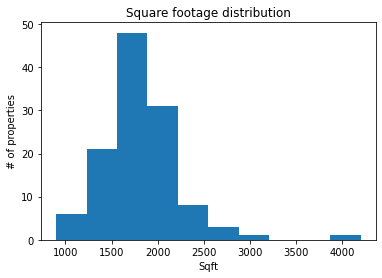

In [42]:
plt.hist(X_train['sqft'])
plt.title('Square footage distribution')
plt.xlabel('Sqft')
plt.ylabel('# of properties')
plt.show()

It looks like the outliers may be skewing the data. We will remove the top 3% of square footage data:

In [43]:
# Make a mask to trim off top 3% of square footage
q_cutoff = X_train['sqft'].quantile(0.97)
mask = X_train['sqft'] < q_cutoff
tr_X_train = X_train[mask]
tr_y_train = y_train[mask]

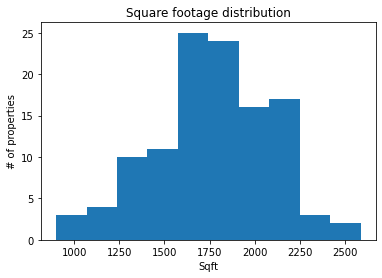

In [44]:
# Recheck the sqft distribution
plt.hist(tr_X_train['sqft'])
plt.title('Square footage distribution')
plt.xlabel('Sqft')
plt.ylabel('# of properties')
plt.show()

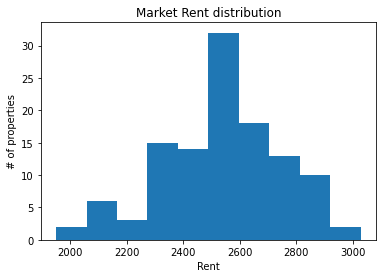

In [45]:
plt.hist(tr_y_train)
plt.title('Market Rent distribution')
plt.xlabel('Rent')
plt.ylabel('# of properties')
plt.show()

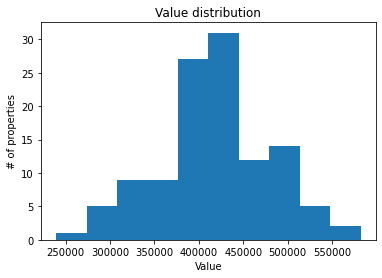

In [46]:
plt.hist(tr_X_train['value'])
plt.title('Value distribution')
plt.xlabel('Value')
plt.ylabel('# of properties')
plt.show()

These histograms look pretty normal. We can use Min-Max Scaling on the value, market_rent, and sqft features. Let's see if the mins/max are fairly similar between both the test and train sets. 

In [47]:
tr_X_train['sqft'].max(), X_test['sqft'].max()

(2587, 3528)

Those values are too different, we cannot use Min Max Scaling. Let's use Standard Scaler instead on square footage and value. 

In [48]:
# create a copy of df
scaled_tr_X_train = tr_X_train.copy()
# create list of columns to be transformed
colnames = ['beds', 'baths', 'value', 'sqft', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement']
features = scaled_tr_X_train[colnames]
valSqftscaler = StandardScaler().fit(features.values)
features = valSqftscaler.transform(features.values)

In [49]:
scaled_tr_X_train[colnames] = features
scaled_tr_X_train.shape

(115, 41)

In [50]:
scaled_tr_X_train.columns

Index(['beds', 'baths', 'sqft', 'value', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement', 'City_Aurora',
       'City_Brighton', 'City_Broomfield', 'City_Castle Pines',
       'City_Castle Rock', 'City_Centennial', 'City_Commerce City',
       'City_Denver', 'City_Erie', 'City_Henderson', 'City_Highlands Ranch',
       'City_Lakewood', 'City_Littleton', 'City_Morrison', 'City_Northglenn',
       'City_Parker', 'City_Thornton', 'City_Westminster',
       'District_Adams-Arapahoe 28J School District',
       'District_Brighton 27J School District',
       'District_Cherry Creek 5 School District',
       'District_Denver County 1 School District',
       'District_Douglas County RE 1 School District',
       'District_Jefferson County R-1 School District',
  

In [51]:
# In case I want to transform x, y, z
#scaled_tr_X_train['x'] = math.sin
#scaled_tr_X_train['y'] = 
#scaled_tr_X_train['z'] = 
#  x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
#    y = r * math.sin(theta) * math.sin(phi)
#    z = r * math.cos(theta)

The X_train data is now transformed. Let's look at it:

In [52]:
scaled_tr_X_train.describe()

,beds,baths,sqft,value,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,...,District_Adams-Arapahoe 28J School District,District_Brighton 27J School District,District_Cherry Creek 5 School District,District_Denver County 1 School District,District_Douglas County RE 1 School District,District_Jefferson County R-1 School District,District_Littleton 6 School District,District_Mapleton 1 School District,District_St. Vrain Valley RE 1J School District,District_Westminster 50 School District
count,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,1.150000e+02,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,1.737740e-16,-3.610638e-16,-3.234128e-16,-1.127600e-15,-1.337095e-16,-5.792468e-17,-4.112652e-16,5.367687e-16,-1.182629e-15,3.572022e-17,...,0.156522,0.043478,0.234783,0.139130,0.130435,0.086957,0.017391,0.008696,0.008696,0.043478
std,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,1.004376e+00,...,0.364939,0.204824,0.425718,0.347597,0.338255,0.283004,0.131296,0.093250,0.093250,0.204824
min,-2.013444e+00,-2.662700e+00,-2.671703e+00,-2.806163e+00,-1.624535e+00,-1.144692e+00,-1.685885e+00,-1.393700e+00,-2.956564e+00,-9.091428e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.752697e-01,-5.653678e-01,-5.962133e-01,-5.555352e-01,-6.411935e-01,-1.007485e+00,-1.019989e+00,-9.167201e-01,-2.781198e-01,-6.942059e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-5.752697e-01,-5.653678e-01,7.931436e-02,-4.138033e-02,-7.463536e-02,5.733685e-01,-1.611490e-01,4.973584e-01,-4.178647e-02,-3.257428e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.629046e-01,4.832983e-01,6.753681e-01,5.665908e-01,8.619018e-01,7.830127e-01,9.767968e-02,8.598520e-01,9.823245e-01,1.041309e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.301079e+00,2.580631e+00,2.484926e+00,2.593644e+00,1.553272e+00,1.495462e+00,1.627122e+00,2.005527e+00,1.218658e+00,2.161383e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
scaled_tr_X_train.shape

(115, 41)

## 4.7 PCA Dimension Reduction of Sparse Matrix <a id='4.6_Train/Test_Split'></a>

After dummy encoding the district and city information, we have too many features and a lot of the matrix is sparse. Let's do PCA and reduce the dimensionality.

In [54]:
# create a copy of df
reduced_X_train = scaled_tr_X_train.copy()
# create list of columns to be transformed
colnames = ['City_Aurora',
       'City_Brighton', 'City_Broomfield', 'City_Castle Pines',
       'City_Castle Rock', 'City_Centennial', 'City_Commerce City',
       'City_Denver', 'City_Erie', 'City_Henderson', 'City_Highlands Ranch',
       'City_Lakewood', 'City_Littleton', 'City_Morrison', 'City_Northglenn',
       'City_Parker', 'City_Thornton', 'City_Westminster',
       'District_Adams-Arapahoe 28J School District',
       'District_Brighton 27J School District',
       'District_Cherry Creek 5 School District',
       'District_Denver County 1 School District',
       'District_Douglas County RE 1 School District',
       'District_Jefferson County R-1 School District',
       'District_Littleton 6 School District',
       'District_Mapleton 1 School District',
       'District_St. Vrain Valley RE 1J School District',
       'District_Westminster 50 School District']
features = reduced_X_train[colnames]
pca = PCA().fit(features.values)
numfeatures = range(pca.n_components_)

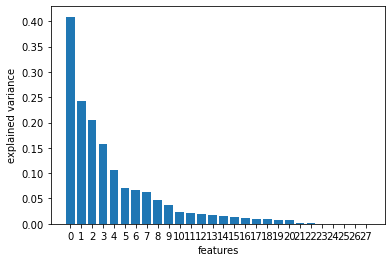

In [55]:
plt.bar(numfeatures, pca.explained_variance_)
plt.xticks(numfeatures)
plt.xlabel('features')
plt.ylabel('explained variance')
plt.show()

From the plots, let's use n_components = 4. 

In [56]:
pca = PCA(n_components=4)
pca.fit(features.values)
features = pca.transform(features.values)

In [57]:
df = pd.DataFrame(features)
df.shape

(115, 4)

In [58]:
reduced_X_train.shape

(115, 41)

In [59]:
reduced_X_train = reduced_X_train[reduced_X_train.columns[~reduced_X_train.columns.isin(colnames)]]

In [60]:
reduced_X_train.shape

(115, 13)

In [61]:
reduced_X_train = pd.concat([reduced_X_train.reset_index(drop=True), df.reset_index(drop=True)], axis = 1)

In [62]:
reduced_X_train.shape

(115, 17)

## 4.8 Transformation of test data <a id='4.6_Train/Test_Split'></a>

First, let's use the previously fit scaling tool to scale the test data. 

In [63]:
# create a copy of df
scaled_X_test = X_test.copy()
# create list of columns to be transformed
colnames = ['beds', 'baths', 'value', 'sqft', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement']
features = scaled_X_test[colnames]
features = valSqftscaler.transform(features.values)

In [64]:
scaled_X_test[colnames] = features
scaled_X_test.shape

(51, 41)

Now perform the dimensionality reduction.

In [65]:
# create a copy of df
reduced_X_test = scaled_X_test.copy()
# create list of columns to be transformed
colnames = ['City_Aurora',
       'City_Brighton', 'City_Broomfield', 'City_Castle Pines',
       'City_Castle Rock', 'City_Centennial', 'City_Commerce City',
       'City_Denver', 'City_Erie', 'City_Henderson', 'City_Highlands Ranch',
       'City_Lakewood', 'City_Littleton', 'City_Morrison', 'City_Northglenn',
       'City_Parker', 'City_Thornton', 'City_Westminster',
       'District_Adams-Arapahoe 28J School District',
       'District_Brighton 27J School District',
       'District_Cherry Creek 5 School District',
       'District_Denver County 1 School District',
       'District_Douglas County RE 1 School District',
       'District_Jefferson County R-1 School District',
       'District_Littleton 6 School District',
       'District_Mapleton 1 School District',
       'District_St. Vrain Valley RE 1J School District',
       'District_Westminster 50 School District']
features = reduced_X_test[colnames]


In [66]:
pca

PCA(n_components=4)

In [67]:
# Transform the test set
features = pca.transform(features.values)

In [68]:
# Remove all the columns affected by PCA
reduced_X_test = reduced_X_test[reduced_X_test.columns[~reduced_X_test.columns.isin(colnames)]]

In [69]:
reduced_X_test.shape

(51, 13)

In [70]:
# make temp df from features, makes code more readable during concatenation
df = pd.DataFrame(features)
# Concat data from feature reduction to test data
reduced_X_test = pd.concat([reduced_X_test.reset_index(drop=True), df.reset_index(drop=True)], axis = 1)

In [71]:
reduced_X_test.shape

(51, 17)